In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
import string 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\huramabi.nziayotchou\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\huramabi.nziayotchou\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\huramabi.nziayotchou\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


In [52]:
# Import Data

real = pd.read_csv('fake-and-real-news-dataset\True.csv')
fake = pd.read_csv('fake-and-real-news-dataset\Fake.csv')
real.shape,fake.shape

((21417, 4), (23481, 4))

In [14]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [15]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [16]:
real['label'] = 0
fake['label'] = 1

## Combine the dataframes

dataCombined = pd.concat([real,fake], ignore_index=True, sort=False)
dataCombined.tail()

,title,text,subject,date,label
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",1


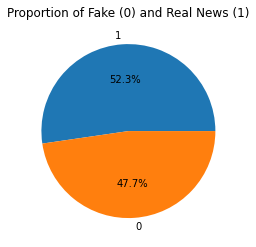

In [17]:
## Visualize the data
g= plt.pie(dataCombined["label"].value_counts().values,explode=[0,0],labels=dataCombined['label'].value_counts().index, autopct='%1.1f%%')
plt.title('Proportion of Fake (0) and Real News (1)')
plt.show()



<AxesSubplot:xlabel='subject', ylabel='count'>

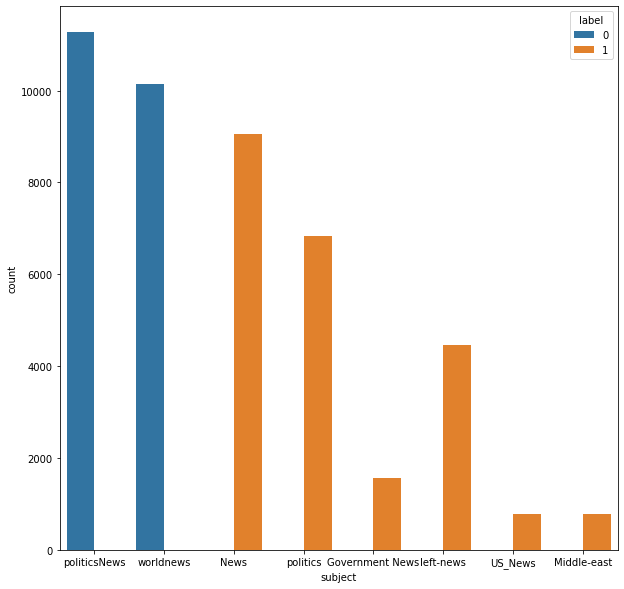

In [18]:
plt.figure(figsize=(10,10))
sns.countplot(x="subject", data=dataCombined, hue="label")

In [19]:
# combine title ,subject and body

dataCombined['combined'] = dataCombined['subject'] + ' ' + dataCombined['title'] + ' ' + dataCombined['text']

In [20]:
## Clean the data

# Remove the punctuation
def remove_punctuation(text):
    return re.sub('[%s]' % re.escape(string.punctuation), '', text)

# Remove the stopwords
def remove_stopwords(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

# Remove the numbers
def remove_numbers(text):
    return ''.join([i for i in text if not i.isdigit()])

# HTML parser
from bs4 import BeautifulSoup

def html_parser(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# lemmatize the text
from nltk.stem import WordNetLemmatizer
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

def clean_text(text):
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = html_parser(text)
    text = lemmatize_text(text)
    return text



In [24]:
dataCombined['combined'] = dataCombined['combined'].apply(clean_text)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(dataCombined['combined'], dataCombined['label'], random_state=42)

In [62]:
# Tokenize the data

tokens = text.Tokenizer(num_words=10000)
tokens.fit_on_texts(X_train)
X_train_tokenized = tokens.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(X_train_tokenized, maxlen=200)

X_test_tokenized = tokens.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test_tokenized, maxlen=200)


In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33673, 200), (11225, 200), (33673,), (11225,))

In [39]:
# Build the model


model = Sequential()
model.add(Embedding(10000, 64, input_length=200, trainable=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_6 (LSTM)               (None, 200, 100)          66000     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 789,665
Trainable params: 789,665
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.3, shuffle=True, verbose=1)

Epoch 1/10
369/369 [==============================] - 371s 1s/step - loss: 0.1506 - accuracy: 0.9453 - val_loss: 0.0703 - val_accuracy: 0.9767
Epoch 2/10
369/369 [==============================] - 374s 1s/step - loss: 0.0399 - accuracy: 0.9878 - val_loss: 0.0353 - val_accuracy: 0.9889
Epoch 3/10
369/369 [==============================] - 370s 1s/step - loss: 0.0145 - accuracy: 0.9961 - val_loss: 0.0311 - val_accuracy: 0.9909
Epoch 4/10
369/369 [==============================] - 361s 978ms/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0363 - val_accuracy: 0.9907
Epoch 5/10
369/369 [==============================] - 351s 953ms/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.0465 - val_accuracy: 0.9865
Epoch 6/10
369/369 [==============================] - 353s 957ms/step - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.0582 - val_accuracy: 0.9870
Epoch 7/10
369/369 [==============================] - 353s 958ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.0416 - val_accu

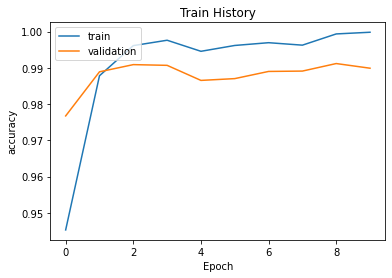

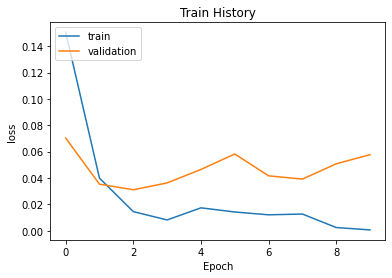

In [41]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
show_train_history(history,'accuracy','val_accuracy')
show_train_history(history,'loss','val_loss')

In [42]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Testing loss \t', scores[0]*100)
print('Testing accuracy ', scores[1]*100)

351/351 [==============================] - 23s 65ms/step - loss: 0.0488 - accuracy: 0.9924
Testing loss 	 4.8801470547914505
Testing accuracy  99.24275875091553


In [64]:
predict=model.predict(X_test)



In [74]:
predictions = predict > 0.9
predictions

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [ True],
       [False]])

In [75]:
print(classification_report(y_test, predictions, target_names=['real', 'fake']))


              precision    recall  f1-score   support

        real       0.98      1.00      0.99      5396
        fake       1.00      0.98      0.99      5829

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [44]:
predict

array([[1.0000000e+00],
       [9.9999988e-01],
       [1.0000000e+00],
       ...,
       [4.5780121e-06],
       [1.0000000e+00],
       [1.2555752e-05]], dtype=float32)

ValueError: in user code:

    File "C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\huramabi.nziayotchou\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_5" (type Sequential).
    
    Input 0 of layer "lstm_6" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None
